In [1]:
# @title 1. Install Libraries
!pip install tensorflow
!pip install opencv-python
!pip install wordcloud

In [2]:
# Mount Google Drive (essential for accessing your data)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title 2. Import Libraries
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
from tqdm.notebook import tqdm # Using tqdm.notebook for Colab-friendly progress bars
import warnings
from collections import defaultdict
import tensorflow as tf # Imported as it was in your original code, though not directly used in the data prep steps here.

warnings.filterwarnings('ignore') # Suppress warnings



In [4]:
# @title 3. Define XML Parsing Function

def parse_reports_from_xml(xml_folder, image_base_folder):
    """
    Parses XML files to extract image filenames and combined report text
    (from FINDINGS and IMPRESSION sections).

    Args:
        xml_folder (str): Path to the directory containing XML report files.
        image_base_folder (str): Base path where images are stored.

    Returns:
        pd.DataFrame: A DataFrame with 'image' (full image path) and 'report' columns.
    """
    data = []
    # Loop through all files in the XML folder
    for file in os.listdir(xml_folder):
        if file.endswith('.xml'):
            try:
                tree = ET.parse(os.path.join(xml_folder, file))
                root = tree.getroot()

                # Get image file names (inside MedlineCitation / Article / parentImage)
                # Note: This looks for 'parentImage' tags directly under the root or its descendants.
                # Your second data extraction block (Cell 5) is more robust for 'image_id' within 'parentImage' attributes.
                image_filenames = [img.text for img in root.findall(".//parentImage")]

                # Get report text from FINDINGS and IMPRESSION tags
                findings = root.findtext('.//FINDINGS')
                impression = root.findtext('.//IMPRESSION')

                report = ''
                if findings:
                    report += findings + ' '
                if impression:
                    report += impression

                # Create a record for each image associated with the report
                for img_name in image_filenames:
                    data.append({
                        'image': os.path.join(image_base_folder, img_name),
                        'report': report.strip()
                    })
            except Exception as e:
                print(f"Error parsing XML file {file}: {e}")
    return pd.DataFrame(data)

# Define your data paths
# IMPORTANT: Ensure these paths accurately point to your unzipped data folders in Google Drive.
xml_dir = r"/content/drive/MyDrive/Colab Notebooks /NLMCXR_reports/ecgen-radiology"
image_base = r"/content/drive/MyDrive/Colab Notebooks /NLMCXR_png"

# (Optional: Print to verify)
print(f"Working XML Directory: {xml_dir}")
print(f"Working Image Base Directory: {image_base}")

# Parse the XML reports into a DataFrame using the first parsing method
# NOTE: This `df` will be overwritten by the more detailed parsing in Cell 5,
#       but it serves to show the initial approach you had.

df = parse_reports_from_xml(xml_dir, image_base)
print("\nInitial DataFrame (from first parsing method) head:")
print(df.head())
print(f"Initial DataFrame shape: {df.shape}")

# SKIP EXPLANATION: The duplicate `drive.mount('/content/drive')` and
# `columns = ["image_id", "caption", ...]` followed by an empty DataFrame
# initialization were redundant as they are handled better in subsequent cells.
# The `print(len(os.listdir(image_path)))` after the empty df was also skipped
# as it's more relevant to the detailed parsing step.

Working XML Directory: /content/drive/MyDrive/Colab Notebooks /NLMCXR_reports/ecgen-radiology
Working Image Base Directory: /content/drive/MyDrive/Colab Notebooks /NLMCXR_png

Initial DataFrame (from first parsing method) head:
                                               image report
0  /content/drive/MyDrive/Colab Notebooks /NLMCXR...       
1  /content/drive/MyDrive/Colab Notebooks /NLMCXR...       
2  /content/drive/MyDrive/Colab Notebooks /NLMCXR...       
3  /content/drive/MyDrive/Colab Notebooks /NLMCXR...       
4  /content/drive/MyDrive/Colab Notebooks /NLMCXR...       
Initial DataFrame shape: (7494, 2)


In [5]:
# @title 4. Detailed XML Data Extraction and Image Processing
# Path to the folder containing chest X-ray images
image_folder = r"/content/drive/MyDrive/Colab Notebooks /NLMCXR_png"
xml_folder = r"/content/drive/MyDrive/Colab Notebooks /NLMCXR_reports/ecgen-radiology"

# Define the column structure for the final DataFrame
columns = ['image_id', 'caption', 'comparison', 'indication', 'findings', 'impression', 'height', 'width']

# Initialize a list to store row dictionaries (faster than appending to a DataFrame)
data = []

# Loop through all XML files in the folder with a progress bar
print(f"Starting detailed XML parsing from {xml_folder}...")
for file in tqdm(os.listdir(xml_folder), desc="Processing XML files"):
    if file.endswith(".xml"):
        try:
            # Parse the XML file
            xml_path = os.path.join(xml_folder, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Extract sections from the medical report using their labels
            comparison = root.find(".//AbstractText[@Label='COMPARISON']")
            indication = root.find(".//AbstractText[@Label='INDICATION']")
            findings = root.find(".//AbstractText[@Label='FINDINGS']")
            impression = root.find(".//AbstractText[@Label='IMPRESSION']")

            # Safely extract text from each section (if exists, else empty string)
            comparison = comparison.text if comparison is not None else ''
            indication = indication.text if indication is not None else ''
            findings = findings.text if findings is not None else ''
            impression = impression.text if impression is not None else ''

            # Loop through each associated 'parentImage' entry in the XML
            for x in root.findall("parentImage"):
                image_id = x.attrib.get('id') + ".png" if x.attrib.get('id') else None # Get image ID and append .png
                caption = '' if x.find('caption') is None else x.find('caption').text

                if image_id: # Only proceed if image_id was successfully extracted
                    full_image_path = os.path.join(image_folder, image_id)

                    # Check if the image file actually exists
                    if os.path.exists(full_image_path):
                        image = cv2.imread(full_image_path)
                        if image is not None:
                            height, width, _ = image.shape  # Get image dimensions

                            # Append a new row to the data list
                            data.append({
                                'image_id': image_id,
                                'caption': caption,
                                'comparison': comparison,
                                'indication': indication,
                                'findings': findings,
                                'impression': impression,
                                'height': height,
                                'width': width
                            })
                        else:
                            # This handles cases where cv2.imread fails (e.g., corrupted image)
                            print(f"Warning: Could not read image file (might be corrupted or invalid format): {full_image_path}")
                    else:
                        print(f"Warning: Image file not found: {full_image_path}")
                else:
                    print(f"Warning: image_id not found in XML entry for file: {file}")

        except ET.ParseError as e:
            print(f"Error parsing XML file {file}: {e}")
        except Exception as e:
            # Catch any other unexpected errors during processing a file
            print(f"An unexpected error occurred while processing {file}: {e}")

# Convert the collected list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data, columns=columns)

print("\nDetailed DataFrame head:")
print(df.head())
print(f"Detailed DataFrame shape: {df.shape}")

# Show example row for 'CXR1_1_IM-0001-3001.png' if it exists
example_row = df[df['image_id']=='CXR1_1_IM-0001-3001.png']
if not example_row.empty:
    print("\nExample row for CXR1_1_IM-0001-3001.png:")
    print(example_row)
else:
    print("\nExample image CXR1_1_IM-0001-3001.png not found in the DataFrame.")

Starting detailed XML parsing from /content/drive/MyDrive/Colab Notebooks /NLMCXR_reports/ecgen-radiology...


Processing XML files:   0%|          | 0/3965 [00:00<?, ?it/s]


Detailed DataFrame head:
                        image_id  \
0  CXR3681_IM-1833-0001-0001.png   
1  CXR3681_IM-1833-0001-0002.png   
2  CXR3676_IM-1829-0001-0001.png   
3  CXR3676_IM-1829-0001-0002.png   
4       CXR3667_IM-1824-2001.png   

                                             caption  \
0                          Xray Chest PA and Lateral   
1                          Xray Chest PA and Lateral   
2                          Xray Chest PA and Lateral   
3                          Xray Chest PA and Lateral   
4  PA and lateral views of the chest, XXXX, XXXX ...   

                                          comparison  \
0                                               None   
1                                               None   
2  Comparison is XXXX to XXXX examination dated X...   
3  Comparison is XXXX to XXXX examination dated X...   
4                                               None   

                                        indication  \
0  Right-sided chest pain and

In [6]:
# @title 5. Path Creation and Initial Data Cleaning

# This function creates a relative path.
# IMPORTANT: This relative path is based on your local `NLMCXR_png/` structure
# within the context of the `images` and `findings` dictionary keys.
# For direct file access later, ensure you combine it with the base_folder.
def absolute_path(x):
    '''Creates a "relative" path for internal tracking based on your structure.
       It assumes 'NLMCXR_png/' is a base prefix for image IDs.'''
    return 'NLMCXR_png/' + x

df['Image_path'] = df['image_id'].apply(lambda x : absolute_path(x)) # making the paths absolute

print("DataFrame head with 'Image_path' column:")
print(df.head(5))

print("\nMissing values before dropping:")
print(df.isnull().sum())

# Select relevant columns for the next steps and drop rows with any missing values
data = df[['image_id', 'findings', 'height', 'width', 'Image_path']].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"\nShape before dropping missing values: {data.shape}")
data = data.dropna(axis=0) # drop all rows that have any missing values in the selected columns
print(f"Shape after dropping missing values: {data.shape}")

print("\nMissing values after dropping:")
print(data.isnull().sum())

print("\nExample of 'Image_path' column after cleaning:")
print(data.Image_path.head())

DataFrame head with 'Image_path' column:
                        image_id  \
0  CXR3681_IM-1833-0001-0001.png   
1  CXR3681_IM-1833-0001-0002.png   
2  CXR3676_IM-1829-0001-0001.png   
3  CXR3676_IM-1829-0001-0002.png   
4       CXR3667_IM-1824-2001.png   

                                             caption  \
0                          Xray Chest PA and Lateral   
1                          Xray Chest PA and Lateral   
2                          Xray Chest PA and Lateral   
3                          Xray Chest PA and Lateral   
4  PA and lateral views of the chest, XXXX, XXXX ...   

                                          comparison  \
0                                               None   
1                                               None   
2  Comparison is XXXX to XXXX examination dated X...   
3  Comparison is XXXX to XXXX examination dated X...   
4                                               None   

                                        indication  \
0  Right-sided

Displaying first 10 images with findings (if available):


<Figure size 2000x1500 with 0 Axes>


Displaying single image example: /content/drive/MyDrive/Colab Notebooks/NLMCXR_png/CXR37_IM-1847-0001-0001.png
Image not found at: /content/drive/MyDrive/Colab Notebooks/NLMCXR_png/CXR37_IM-1847-0001-0001.png


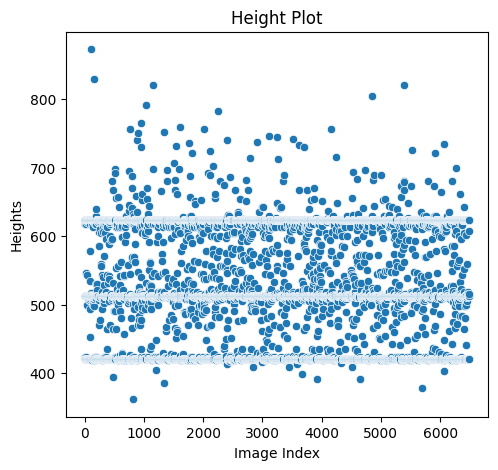

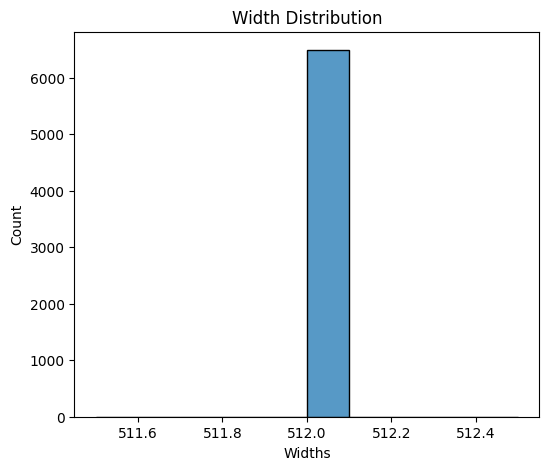

<Figure size 640x480 with 0 Axes>

In [7]:
# @title 6. Image Visualization and Data Distribution

# Base folder for images (using the one mounted from Google Drive)
base_folder = r"/content/drive/MyDrive/Colab Notebooks/NLMCXR_png"

# Display a few sample images with their findings
fig = plt.figure(figsize=(20, 15))
count = 1

print("Displaying first 10 images with findings (if available):")
# Loop over the first 10 rows of the 'data' DataFrame
for idx, row in data[:10].iterrows():
    image_id = row['image_id']
    findings_text = row['findings']

    # Build the full path to the image
    filename = os.path.join(base_folder, image_id)

    # Try to read the image
    img = cv2.imread(filename)

    # If image couldn't be read, skip
    if img is None:
        print(f"Warning: Unable to read image {filename}. Skipping.")
        continue

    # Convert from BGR (OpenCV default) to RGB (Matplotlib default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Add subplot
    ax = fig.add_subplot(5, 2, count, xticks=[], yticks=[])

    # Display image
    ax.imshow(img)

    # Set title (truncated findings text to avoid clutter)
    title_text = findings_text[:100] + '...' if findings_text else "No Findings"
    ax.set_title(title_text, fontsize=10)

    count += 1
    if count > 10: # Stop after 10 images
        break

plt.tight_layout() # Adjust layout
plt.show()


# Example of a single image display
# Choose an index (e.g., 5)
index = 5
filename_to_display = os.path.basename(data['Image_path'].iloc[index])
image_path_full = os.path.join(base_folder, filename_to_display)

print(f"\nDisplaying single image example: {image_path_full}")
img_single = cv2.imread(image_path_full)

if img_single is None:
    print(f"Image not found at: {image_path_full}")
else:
    img_single = cv2.cvtColor(img_single, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 7))
    plt.imshow(img_single)
    plt.axis('off')
    plt.title(f"Image: {filename_to_display}")
    plt.show()

    findings_single = data['findings'].iloc[index]
    print("\nFindings/Comments for single image example:")
    print(findings_single if findings_single else "No findings available.")

# Plot height and width distributions
plt.figure(figsize=(12, 5))

# Height Plot (Scatter)
plt.subplot(1, 2, 1)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('Image Index')
sns.scatterplot(x=range(len(data.height.values)), y=data.height.values)

# Width Plot (Histogram) - Re-creating a separate figure as you had it
plt.figure(figsize=(6, 5))
plt.title('Width Distribution')
sns.histplot(data.width.values, bins=10, kde=False)
plt.xlabel('Widths')
plt.ylabel('Count')
plt.show() # Display the width histogram

plt.tight_layout() # Adjust subplots to fit in figure area
plt.show() # Display the height plot (if not already shown by tight_layout on the first figure)

# SKIP EXPLANATION: The second `plt.tight_layout()` and `plt.show()` after the
# height/width plots were slightly redundant if `plt.show()` was called after each figure creation.
# I've adjusted to ensure both plots are displayed correctly.

Total Number of Unique Patient IDs (after processing): 3350
Example: Patient ID 'NLMCXR_png/CXR1001_IM-0004' has 2 images and findings: Interstitial markings are diffusely prominent thro...


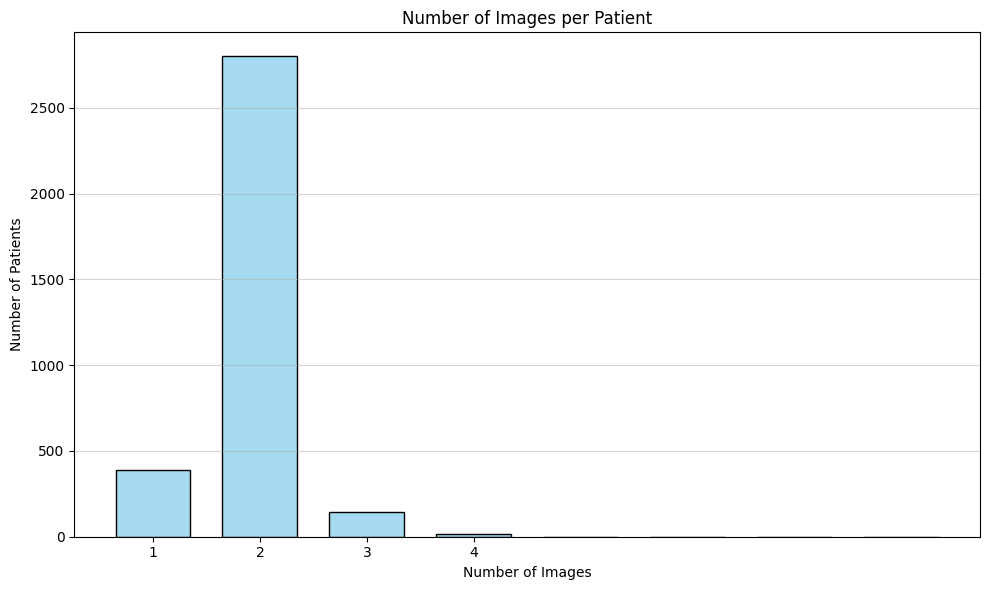


Number of patients in Train set: 2500
Number of patients in CV set: 500
Number of patients in Test set: 350

Example images for a patient in train set: Patient ID not found in train set


In [8]:
# @title 7. Patient-Level Aggregation and Data Splitting

images = {} # Stores count of images per unique patient ID
findings = {} # Stores findings for each unique patient ID (assuming one report per patient ID)

# Iterate through the cleaned 'data' DataFrame
for img_path_relative, fin in data[['Image_path', 'findings']].values:
    # Example img_path_relative: 'NLMCXR_png/CXR1_1_IM-0001-3001.png'
    # We want to extract 'NLMCXR_png/CXR1_1_IM-0001' as the patient ID prefix
    # Split by '.' to remove file extension, then split by '-' to remove the image series number
    parts = img_path_relative.split('.')
    file_prefix = parts[0] # e.g., 'NLMCXR_png/CXR1_1_IM-0001-3001'

    # Remove the last part after the last hyphen (which represents the image series number)
    patient_id_parts = file_prefix.split('-')
    patient_id_parts.pop(len(patient_id_parts) - 1) # Removes '3001' from 'CXR1_1_IM-0001-3001'
    patient_id = ('-'.join(patient_id_parts)) # Reconstructs 'NLMCXR_png/CXR1_1_IM-0001'

    if patient_id not in images.keys():
        images[patient_id] = 1
        findings[patient_id] = fin
    else:
        images[patient_id] += 1
        findings[patient_id] = fin

print(f'Total Number of Unique Patient IDs (after processing): {len(images.keys())}')
print(f"Example: Patient ID 'NLMCXR_png/CXR1001_IM-0004' has {images['NLMCXR_png/CXR1001_IM-0004']} images and findings: {findings['NLMCXR_png/CXR1001_IM-0004'][:50]}...")


# Visualize the distribution of images per patient
plt.figure(figsize=(10, 6))
sns.histplot(
    list(images.values()),
    bins=range(1, 6), # Assuming max images per person is 4, so bins up to 5 for clarity
    discrete=True,
    shrink=0.7,
    color='skyblue',
    edgecolor='black'
)
plt.title('Number of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.xticks(np.arange(1, 5, 1)) # Set x-ticks at 1, 2, 3, 4
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# Function to split patient IDs into train, validation, and test sets
def train_test_split_patients(patient_ids_dict, train_size=2500, cv_size=500, test_size=350):
    """
    Splits patient IDs into train, cross-validation, and test sets.

    Args:
        patient_ids_dict (dict): Dictionary where keys are patient IDs.
        train_size (int): Number of patients for training.
        cv_size (int): Number of patients for cross-validation.
        test_size (int): Number of patients for testing.

    Returns:
        tuple: (train_patient_ids, cv_patient_ids, test_patient_ids) lists.
    """
    persons = list(patient_ids_dict.keys())
    # Ensure there are enough persons to split
    if len(persons) < (train_size + cv_size + test_size):
        warnings.warn("Not enough patient IDs for the specified split sizes. Adjusting split.")
        train_size = int(len(persons) * 0.7)
        cv_size = int(len(persons) * 0.15)
        test_size = len(persons) - train_size - cv_size

    persons_train = persons[:train_size]
    persons_cv = persons[train_size : train_size + cv_size]
    persons_test = persons[train_size + cv_size : train_size + cv_size + test_size]
    return persons_train, persons_cv, persons_test

images_train, images_cv, images_test = train_test_split_patients(images)

print(f"\nNumber of patients in Train set: {len(images_train)}")
print(f"Number of patients in CV set: {len(images_cv)}")
print(f"Number of patients in Test set: {len(images_test)}")


# Function to combine image paths for each person ID
def combining_images(image_set, dataframe_data):
    """
    Creates a dictionary mapping patient IDs to a list of their image paths.

    Args:
        image_set (list): List of patient IDs (e.g., images_train).
        dataframe_data (pd.DataFrame): The main DataFrame containing 'Image_path'.

    Returns:
        defaultdict: A dictionary where keys are patient IDs and values are lists of image paths.
    """
    image_per_person = defaultdict(list)
    # Optimized loop: iterate through the DataFrame once
    for _, row in dataframe_data.iterrows():
        img_path = row['Image_path']
        # Find which patient_id prefix this image belongs to
        # Re-extract patient_id from img_path for matching with image_set
        parts = img_path.split('.')
        file_prefix = parts[0]
        patient_id_parts = file_prefix.split('-')
        patient_id_parts.pop(len(patient_id_parts) - 1)
        patient_id = ('-'.join(patient_id_parts))

        if patient_id in image_set: # Check if this patient_id belongs to the current set (train/cv/test)
            image_per_person[patient_id].append(img_path)
    return image_per_person

img_per_person_train = combining_images(images_train, data)
img_per_person_cv = combining_images(images_cv, data)
img_per_person_test = combining_images(images_test, data)

print(f"\nExample images for a patient in train set: {img_per_person_train.get('NLMCXR_png/CXR1001_IM-0004', 'Patient ID not found in train set')}")

Found patient with 4 images: NLMCXR_png/CXR3932_IM-2004


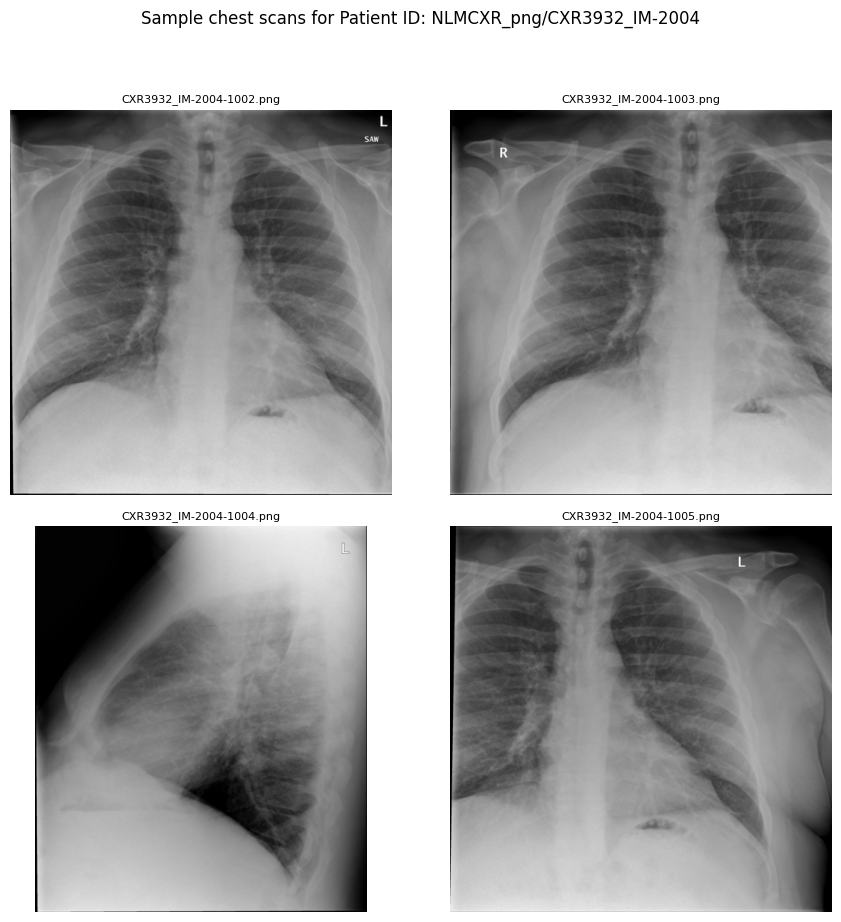


Note: For patients with multiple images, we can consider pairs of images as input.
If a patient has only one image, it will be replicated to form a pair.


In [9]:
# @title 8. Visualizing Multi-Image Patient Scans

# Make sure base_folder is correctly set from the global IMAGE_BASE_DIR
base_folder = image_base # <--- THIS IS THE CRUCIAL FIX for NameError

# Import necessary libraries if they aren't already imported in this cell scope
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def load_image(file_path):
    """Loads an image from the given path, converting BGR to RGB."""
    full_path = os.path.join(base_folder, os.path.basename(file_path)) # Re-construct full path for safe loading
    img = cv2.imread(full_path)
    if img is not None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        print(f"Warning: Could not load image: {full_path}")
        return None

# Find an ID which has 4 images (as per your example)
patient_id_with_4_images = None
for k,v in images.items():
    if v == 4:
        patient_id_with_4_images = k
        break

if patient_id_with_4_images:
    print(f"Found patient with 4 images: {patient_id_with_4_images}")
    # Get the list of actual image files for this patient from the original 'data' DataFrame
    # Filter the original 'data' DataFrame based on the patient_id_with_4_images prefix
    matching_images = data[data['Image_path'].str.startswith(patient_id_with_4_images)]['Image_path'].tolist()

    if len(matching_images) == 4:
        plt.figure(figsize=(9,9))

        titles = [os.path.basename(img_path) for img_path in matching_images] # Use base filename for title

        for i, img_path in enumerate(matching_images):
            plt.subplot(2, 2, i + 1)
            img_loaded = load_image(img_path)
            if img_loaded is not None:
                plt.imshow(img_loaded)
                plt.title(titles[i], fontsize=8)
                plt.axis('off')
            else:
                plt.title(f"Image not loaded: {titles[i]}", fontsize=8)
                plt.axis('off')

        plt.suptitle(f"Sample chest scans for Patient ID: {patient_id_with_4_images}", y=1.02, fontsize=12) # Add a main title
        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
        plt.show()
    else:
        print(f"Error: Expected 4 images for {patient_id_with_4_images}, but found {len(matching_images)}. Cannot display.")
else:
    print("No patient with exactly 4 images found in the dataset for visualization.")

print("\nNote: For patients with multiple images, we can consider pairs of images as input.")
print("If a patient has only one image, it will be replicated to form a pair.")

In [10]:
# @title 9. Create Image Pairs Dataset

import itertools

def create_paired_data(image_per_person_dict, findings_dict):
    """
    Generates a DataFrame with pairs of image paths and their corresponding report.
    If a person has only one image, it's paired with itself.
    If a person has multiple images, all unique pairs are created.

    Args:
        image_per_person_dict (defaultdict): Dict of patient_id -> list of image_paths.
        findings_dict (dict): Dict of patient_id -> report string.

    Returns:
        pd.DataFrame: DataFrame with 'Person_id', 'Image1', 'Image2', 'Report' columns.
    """
    person_id, image1, image2, report = [], [], [], []

    for pid, imgs in tqdm(image_per_person_dict.items(), desc="Creating image pairs"):
        # Ensure we use the base patient ID for looking up findings
        # e.g., turn 'NLMCXR_png/CXR1001_IM-0004' into 'CXR1001_IM-0004'
        # Or even better, use the `findings` dictionary created previously which already has these keys.
        current_report = findings_dict.get(pid, "") # Safely get report for the base pid

        if len(imgs) == 0:
            print(f"Warning: No images found for patient ID: {pid}. Skipping.")
            continue
        elif len(imgs) == 1:
            # If only one image, pair it with itself
            image1.append(imgs[0])
            image2.append(imgs[0])
            person_id.append(pid)
            report.append(current_report)
        else:
            # Create all unique combinations of 2 images
            num = 0
            combinations = itertools.combinations(imgs, 2)
            for i1, i2 in combinations:
                image1.append(i1)
                image2.append(i2)
                # Append a unique identifier to the person_id for each pair if needed,
                # otherwise just the original pid is fine. Here, original pid is sufficient
                # unless you need to track each pair uniquely within the same person.
                # pid + '_' + str(num) was in your original code, which is fine for uniqueness.
                person_id.append(pid + '_' + str(num))
                report.append(current_report)
                num += 1

    data_df = pd.DataFrame()
    data_df['Person_id'] = person_id
    data_df['Image1'] = image1
    data_df['Image2'] = image2
    data_df['Report'] = report

    return data_df

# Create the train, test, and cross-validation datasets
train_df = create_paired_data(img_per_person_train, findings)
test_df = create_paired_data(img_per_person_test, findings)
cv_df = create_paired_data(img_per_person_cv, findings)

print("\nTrain DataFrame head:")
print(train_df.head())
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Test DataFrame shape: {test_df.shape}")
print(f"CV DataFrame shape: {cv_df.shape}")

# Save these intermediate dataframes (before text preprocessing)
train_df.to_csv('train_raw.csv', index=False)
test_df.to_csv('test_raw.csv', index=False)
cv_df.to_csv('cv_raw.csv', index=False)
print("\nRaw train, test, cv data saved to CSV files.")

Creating image pairs:   0%|          | 0/2500 [00:00<?, ?it/s]

Creating image pairs:   0%|          | 0/350 [00:00<?, ?it/s]

Creating image pairs:   0%|          | 0/500 [00:00<?, ?it/s]


Train DataFrame head:
                           Person_id  \
0  NLMCXR_png/CXR3681_IM-1833-0001_0   
1  NLMCXR_png/CXR3676_IM-1829-0001_0   
2         NLMCXR_png/CXR3667_IM-1824   
3    NLMCXR_png/CXR37_IM-1847-0001_0   
4       NLMCXR_png/CXR3664_IM-1822_0   

                                     Image1  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0001.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0001.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0001.png   
4       NLMCXR_png/CXR3664_IM-1822-1001.png   

                                     Image2  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0002.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0002.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0002.png   
4       NLMCXR_png/CXR3664_IM-1822-2001.png   

                                              Report  
0  There are lower lung volumes. There is central...  
1  The cardiomediastinal silhouette appears irreg...  
2  De

In [11]:
# @title 10. Define Text Preprocessing Functions

def lowercase(text_list):
    """Converts all text to lowercase."""
    new_text = []
    for line in text_list:
        if line is not None:
            new_text.append(line.lower())
        else:
            new_text.append("") # Handle None values, replace with empty string
    return new_text

def decontractions(text_list):
    """Performs common English decontractions."""
    new_text = []
    for phrase in text_list:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase) # Replace multiple asterisks with "abuse"
        new_text.append(phrase)
    return new_text

def rem_punctuations(text_list):
    """Removes common punctuations except full stop (.)."""
    punctuations_to_remove = '''!()-[]{};:'"\,<>/?@#$%^&*~'''
    new_text = []
    for line in text_list:
        clean_line = "".join([char for char in line if char not in punctuations_to_remove])
        new_text.append(' '.join(clean_line.split())) # Remove multiple spaces created by replacements
    return new_text

def rem_numbers(text_list):
    """Removes numbers and 'x' characters (like 'xxxx')."""
    new_text = []
    for line in text_list:
        temp = re.sub(r'x+', '', line) # Remove sequences of 'x's
        new_text.append(re.sub(r'\d', '', temp)) # Remove digits
    return new_text

def words_filter(text_list):
    """Removes words less than 2 characters long, except 'no' and 'ct'."""
    new_text = []
    for line in text_list:
        temp_words = line.split()
        filtered_words = []
        for word in temp_words:
            if len(word) <= 2 and word not in ['no', 'ct']:
                continue
            else:
                filtered_words.append(word)
        new_text.append(' '.join(filtered_words))
    return new_text

def multiple_fullstops(text_list):
    """Removes multiple consecutive full stops, replacing them with a single one."""
    new_text = []
    for line in text_list:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text_list):
    """Ensures a space before each full stop (useful for tokenization)."""
    new_text = []
    for line in text_list:
        new_text.append(re.sub(r'\.', ' .', line)) # Add space before dot
    return new_text

def multiple_spaces(text_list):
    """Replaces multiple spaces with a single space."""
    new_text = []
    for line in text_list:
        new_text.append(' '.join(line.split()))
    return new_text

def separting_startg_words(text_list):
    """Adds a space after a full stop if it's directly attached to a word (e.g., 'word.another')."""
    new_text = []
    for line in text_list:
        temp = []
        words = line.split()
        for i, word in enumerate(words):
            if word.startswith('.') and len(word) > 1 and i > 0: # Check if dot is part of a word like ".word"
                # This seems designed to separate ".word" into ". word"
                # Given 'fullstops' function already does ' .', this might be redundant or for specific edge cases.
                # I'll keep it as per your code, but note it may overlap with `fullstops`.
                w = word.replace('.', '. ')
                temp.append(w)
            else:
                temp.append(word)
        new_text.append(' '.join(temp))
    return new_text

def rem_apostrophes(text_list):
    """Removes apostrophes from the text."""
    new_text = []
    for line in text_list:
        new_text.append(re.sub("'", '', line))
    return new_text

def text_preprocessing(text_series):
    """
    Combines all the text preprocessing functions into a single pipeline.

    Args:
        text_series (pd.Series or list): A pandas Series or list of text strings.

    Returns:
        list: A list of preprocessed text strings.
    """
    # Ensure input is a list for consistent function application
    text_list = text_series.tolist() if isinstance(text_series, pd.Series) else list(text_series)

    new_text = lowercase(text_list)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text) # This might add extra spaces next to dots already handled.
    new_text = rem_apostrophes(new_text)
    return new_text

Applying text preprocessing to 'Report' column for train, test, and CV sets...

Train DataFrame head after text preprocessing:
                           Person_id  \
0  NLMCXR_png/CXR3681_IM-1833-0001_0   
1  NLMCXR_png/CXR3676_IM-1829-0001_0   
2         NLMCXR_png/CXR3667_IM-1824   
3    NLMCXR_png/CXR37_IM-1847-0001_0   
4       NLMCXR_png/CXR3664_IM-1822_0   

                                     Image1  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0001.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0001.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0001.png   
4       NLMCXR_png/CXR3664_IM-1822-1001.png   

                                     Image2  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0002.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0002.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0002.png   
4       NLMCXR_png/CXR3664_IM-1822-2001.png   

                                              Report  
0  there ar

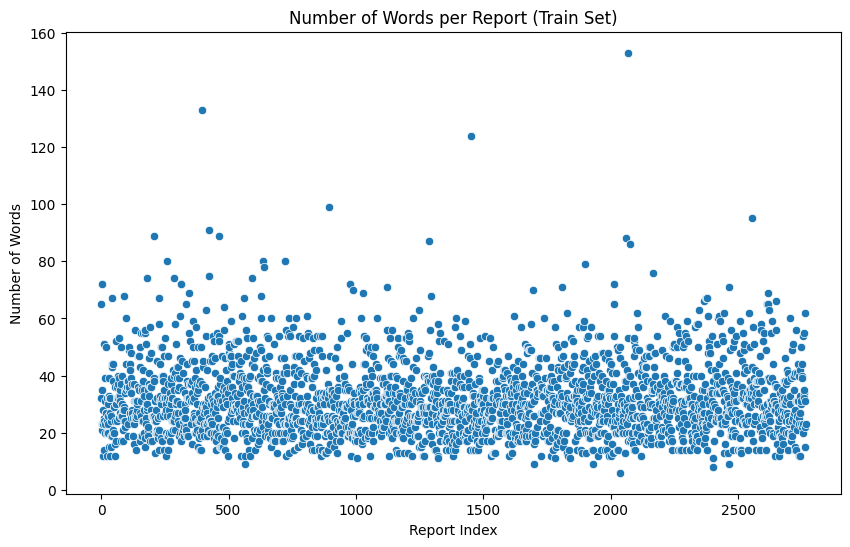


Most reports contain a word count below 100 based on the scatter plot.

Generating Word Cloud for Training Reports:


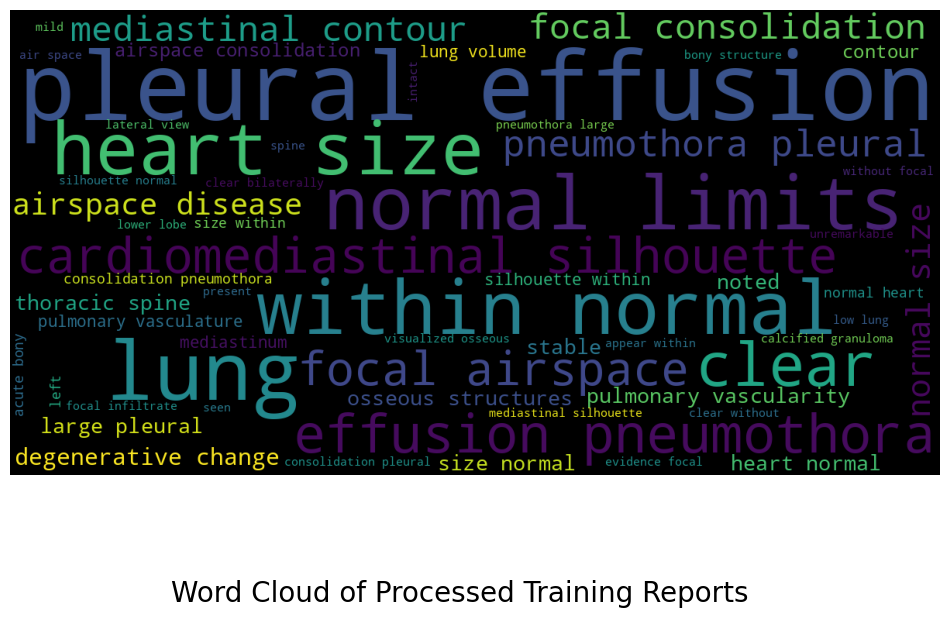

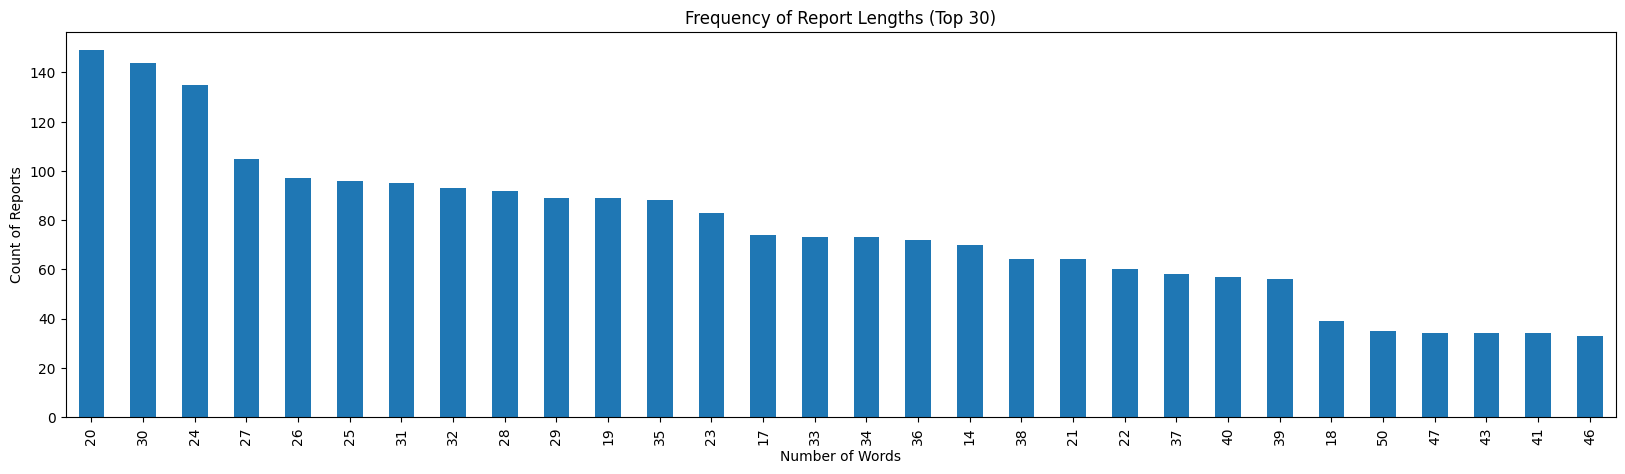


Adding 'startseq' and 'endseq' tokens to reports...

Train DataFrame head after adding start/end tokens:
                           Person_id  \
0  NLMCXR_png/CXR3681_IM-1833-0001_0   
1  NLMCXR_png/CXR3676_IM-1829-0001_0   
2         NLMCXR_png/CXR3667_IM-1824   
3    NLMCXR_png/CXR37_IM-1847-0001_0   
4       NLMCXR_png/CXR3664_IM-1822_0   

                                     Image1  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0001.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0001.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0001.png   
4       NLMCXR_png/CXR3664_IM-1822-1001.png   

                                     Image2  \
0  NLMCXR_png/CXR3681_IM-1833-0001-0002.png   
1  NLMCXR_png/CXR3676_IM-1829-0001-0002.png   
2       NLMCXR_png/CXR3667_IM-1824-2001.png   
3    NLMCXR_png/CXR37_IM-1847-0001-0002.png   
4       NLMCXR_png/CXR3664_IM-1822-2001.png   

                                              Report  
0  startseq there are lower lung

In [12]:
# @title 11. Apply Text Preprocessing and Add Sequence Tokens

print("Applying text preprocessing to 'Report' column for train, test, and CV sets...")

train_df['Report'] = text_preprocessing(train_df['Report'])
test_df['Report'] = text_preprocessing(test_df['Report'])
cv_df['Report'] = text_preprocessing(cv_df['Report'])

print("\nTrain DataFrame head after text preprocessing:")
print(train_df.head())

# Save processed data (optional, but good for checkpoints)
train_df.to_csv('processed_train.csv', index=False)
test_df.to_csv('processed_test.csv', index=False)
cv_df.to_csv('processed_cv.csv', index=False)
print("\nProcessed train, test, cv data (without start/end tokens yet) saved to CSV files.")


# Visualize report length distribution
l = [len(e.split()) for e in train_df['Report'].values] # Number of words in each report

print(f'\nMaximum number of words in a report (Train set): {max(l)}')

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(l)), y=l)
plt.title('Number of Words per Report (Train Set)')
plt.xlabel('Report Index')
plt.ylabel('Number of Words')
plt.show()

print("\nMost reports contain a word count below 100 based on the scatter plot.")


# Word Cloud Visualization
from wordcloud import WordCloud

def show_wordcloud_custom(data_series, title=None):
    """Displays a word cloud for the given text data."""
    text_combined = ' '.join(data_series.astype(str))
    wordcloud = WordCloud(background_color='black', max_words=800, max_font_size=60, scale=3, random_state=1).generate(text_combined)

    fig = plt.figure(1, figsize=(12, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3) # Adjust title position if needed

    plt.imshow(wordcloud)
    plt.show()

print("\nGenerating Word Cloud for Training Reports:")
show_wordcloud_custom(train_df['Report'], title='Word Cloud of Processed Training Reports')


# Word count bar plot
countword = train_df['Report'].str.split().apply(len).value_counts()
plt.figure(figsize=(20, 5))
countword[:30].plot(kind='bar', title='Frequency of Report Lengths (Top 30)')
plt.xlabel('Number of Words')
plt.ylabel('Count of Reports')
plt.show()


# Function to add start and end tokens
def remodelling(text):
    '''Adds start and end tokens to a sentence.'''
    # Check for empty string or None to avoid adding tokens to invalid input
    if pd.isna(text) or text.strip() == "":
        return "startseq endseq" # Or just empty, depending on how you want to handle
    return 'startseq' + ' ' + text + ' ' + 'endseq'

print("\nAdding 'startseq' and 'endseq' tokens to reports...")
train_df['Report'] = train_df['Report'].apply(lambda x : remodelling(x))
test_df['Report'] = test_df['Report'].apply(lambda x : remodelling(x))
cv_df['Report'] = cv_df['Report'].apply(lambda x : remodelling(x))

print("\nTrain DataFrame head after adding start/end tokens:")
print(train_df.head())

In [13]:
# @title 12. Export Final Processed Datasets (Modified for Google Drive Path)
import os
# Define the target directory in Google Drive where you want to save the CSVs
# This should match your 'Colab Notebooks' folder path
SAVE_CSV_DIR = "/content/drive/MyDrive/Colab Notebooks"

# Ensure the directory exists
os.makedirs(SAVE_CSV_DIR, exist_ok=True)
print(f"Saving final processed datasets to: {SAVE_CSV_DIR}")

# Save the final cleaned and structured data
train_df.to_csv(os.path.join(SAVE_CSV_DIR, 'Final_Train_Data.csv'), index=False)
test_df.to_csv(os.path.join(SAVE_CSV_DIR, 'Final_Test_Data.csv'), index=False)
cv_df.to_csv(os.path.join(SAVE_CSV_DIR, 'Final_CV_Data.csv'), index=False)

print("\nFinal processed datasets saved successfully.")
print("- Final_Train_Data.csv")
print("- Final_Test_Data.csv")
print("- Final_CV_Data.csv")

Saving final processed datasets to: /content/drive/MyDrive/Colab Notebooks

Final processed datasets saved successfully.
- Final_Train_Data.csv
- Final_Test_Data.csv
- Final_CV_Data.csv


In [24]:
import nbformat

path = "/content/drive/MyDrive/Colab Notebooks /EDA_and_Data_Preparation_.ipynb"

nb = nbformat.read(path, as_version=4)

if "widgets" in nb["metadata"]:
    del nb["metadata"]["widgets"]

nbformat.write(nb, path)

print("Notebook cleaned successfully:", path)


Notebook cleaned successfully: /content/drive/MyDrive/Colab Notebooks /EDA_and_Data_Preparation_.ipynb
